# Feature Engineering

---

Introduction

Feature engineering is the heart of predictive analytics, transforming raw data into meaningful features that enhance the model’s performance. In our logistics optimization project, this stage is essential for creating features that capture the nuances of our data and improve our predictive capabilities. By building on insights from the EDA, we’ll derive new features like Cost per Mile and Delivery Efficiency (measured as Distance per Time) to quantify efficiency. These features provide refined lenses through which we can analyze operational costs, helping to differentiate efficient routes and drivers from less efficient ones.

In addition to creating new features, we will standardize and encode categorical data to prepare the dataset for machine learning. This structured dataset, rich with engineered features, will form the basis for our predictive models, ultimately allowing us to make informed, data-driven recommendations for logistics optimization.

---

Conclusion

Our feature engineering efforts have enriched the dataset, creating a series of well-defined predictors that will be invaluable in the modeling stage. Cost per Mile and Delivery Efficiency provide quantifiable measures of efficiency, while standardized and encoded categorical data ensure that our models can interpret the dataset effectively. These engineered features not only capture essential operational characteristics but also serve as levers for optimization. By completing this stage, we have crafted a dataset that is primed for predictive modeling, ready to unlock actionable insights into logistics operations.

---


Loading and Preparing Data

In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
import sys
import os

# 'scripts' is in the same parent directory as 'notebooks'
sys.path.append(os.path.abspath("../scripts"))

from feature_engineering import create_features

In [70]:
# Load the cleaned data
logistics_df = pd.read_csv('../data/raw/logistics_df.csv')
logistics_df.head()

,Route ID,Driver ID,Manifest,Delivery Duration (hours),Date,Fuel Price per Gallon (USD),Actual Distance (miles),Planned Distance (miles),Weather Conditions,Traffic Conditions,...,Toll Costs (USD),Parking Costs (USD),Time Idling (hours),Miles per Gallon,Calculated Fuel Cost (USD),Idle Cost (USD),Fuel Cost Per Mile,Total Operational Cost (USD),Weather Severity,Weather Severity Score
0,MIA/BNA,BC7706,3815805,6.25,2023-02-28,4.0,1690.79,862.13,Snow,Moderate,...,14.42,21.00,0.46,7.03,962.65,0.93,0.57,1659.22,2,2
1,PHX/MCO,ZN7236,7299049,5.67,2023-10-29,3.5,2693.86,1970.77,Heavy Rain,Moderate,...,39.82,7.16,1.65,7.48,1259.91,2.89,0.47,2237.47,2,2
2,MCO/MIA,AW5182,9497986,1.31,2023-09-14,4.0,925.07,1337.27,Heavy Rain,Heavy,...,24.93,10.30,0.83,7.76,476.54,1.66,0.52,1883.15,2,2
3,MIA/DCA,XY7077,7232797,2.38,2023-12-31,4.5,660.51,1833.61,Heavy Rain,Moderate,...,22.28,8.18,0.68,6.83,435.50,1.53,0.66,2538.15,1,1
4,LAS/SAN,HJ7731,2201569,1.24,2023-05-02,4.5,1135.09,428.03,Snow,Light,...,37.74,12.98,0.67,7.84,651.60,1.50,0.57,2169.99,1,1


In [71]:
# Create Cost per Mile
logistics_df['Cost per Mile'] = logistics_df['Calculated Fuel Cost (USD)'] / logistics_df['Actual Distance (miles)']


In [72]:
logistics_df['Cost per Ton-Mile'] = logistics_df['Total Operational Cost (USD)'] / (logistics_df['Load Weight (tons)'] * logistics_df['Actual Distance (miles)'])

In [73]:
# Create Delivery Efficiency feature
logistics_df['Delivery Efficiency'] = logistics_df['Actual Distance (miles)'] / logistics_df['Delivery Duration (hours)']

In [74]:
# Map Customer Satisfaction to numeric values (assuming an ordinal scale)
satisfaction_map = {
    'Very Dissatisfied': 1,
    'Dissatisfied': 2,
    'Neutral': 3,
    'Satisfied': 4,
    'Very Satisfied': 5
}

# Apply the mapping
logistics_df['Customer Satisfaction'] = logistics_df['Customer Satisfaction'].map(satisfaction_map)

inefficient_routes = logistics_df[
    (logistics_df['Calculated Fuel Cost (USD)'] > logistics_df['Calculated Fuel Cost (USD)'].quantile(0.75)) |
    (logistics_df['Delays (hours)'] > logistics_df['Delays (hours)'].quantile(0.75)) |
    (logistics_df['Customer Satisfaction'] < 3)]

Traffic Conditions:
        
Purpose: Helps analyze how traffic impacts delivery time and fuel consumption, allows recommending optimal delivery times or routes.


In [75]:
 # Categorize routes by length
conditions = [
    (logistics_df['Actual Distance (miles)'] < 100),
    (logistics_df['Actual Distance (miles)'] >= 100) & (logistics_df['Actual Distance (miles)'] < 300),
    (logistics_df['Actual Distance (miles)'] >= 300)
    ]
categories = ['Short', 'Medium', 'Long']
logistics_df['Route Length'] = np.select(conditions, categories)

    # Map weather conditions to severity levels
weather_map = {
    'Sunny': 'Low',
    'Cloudy': 'Low',
    'Windy': 'Moderate',
    'Rainy': 'High',
    'Snowy': 'High',
    'Stormy': 'Severe'
    }
logistics_df['Weather Severity'] = logistics_df['Weather Conditions'].map(weather_map)


In [76]:
weather_map = {'Sunny': 1, 'Cloudy': 2, 'Windy': 3, 'Rainy': 4, 'Snowy': 5, 'Stormy': 6}
logistics_df['Weather Severity Score'] = logistics_df['Weather Conditions'].map(weather_map)

In [77]:
logistics_df['Severe Weather'] = logistics_df['Weather Conditions'].apply(lambda x: 1 if x in ['Rainy', 'Snowy', 'Stormy'] else 0)

In [78]:
severity_mapping = {'Clear': 0, 'Light Rain': 1, 'Heavy Rain': 2, 'Snow': 3, 'Fog': 2}  # Example severity scores
logistics_df['Weather Severity Index'] = logistics_df['Weather Conditions'].map(severity_mapping)

In [79]:
inefficient_routes = logistics_df[
    (logistics_df['Cost per Mile'] > logistics_df['Cost per Mile'].quantile(0.75)) |
    (logistics_df['Delays (hours)'] > logistics_df['Delays (hours)'].quantile(0.75)) |
    (logistics_df['Customer Satisfaction'] < 3)
]


In [80]:
route_delivery_time = logistics_df.groupby('Route ID')['Delivery Duration (hours)'].mean()

In [81]:
# Replace instances of `Calculated Fuel Costs (USD)` with `Fuel Cost per Mile`
# Example if calculating average or other metrics
avg_fuel_cost_per_mile = logistics_df['Fuel Cost Per Mile'].mean()

In [82]:
logistics_df['Fuel Cost per Mile'] = logistics_df['Calculated Fuel Cost (USD)'] / logistics_df['Actual Distance (miles)']

In [83]:
logistics_df['Performance Score'] = (1 / (1 + logistics_df['Delays (hours)']) * logistics_df['Customer Satisfaction'] * (1 / (1 + logistics_df['Fuel Cost per Mile'])))

In [84]:
logistics_df['Driver Consistency Score'] = logistics_df.groupby('Driver ID')['Delays (hours)'].transform('mean')

In [85]:
# Calculate Fuel Cost per Mile
logistics_df['Fuel Cost per Mile'] = logistics_df['Calculated Fuel Cost (USD)'] / logistics_df['Actual Distance (miles)']


In [86]:
logistics_df = pd.get_dummies(logistics_df, columns=['Traffic Conditions'], drop_first=False)

In [87]:
# Add a binary target variable for On-Time Delivery
logistics_df['On-Time Delivery'] = np.where(logistics_df['Delays (hours)'] > 1, 0, 1)  # 1 = On-Time, 0 = Delayed

New Features for Driver Experience and Weather Severity
a) Driver Experience on Specific Routes

Assign numeric values based on driver experience to analyze its impact on long and challenging routes.

In [88]:
# Map driver experience to numeric values
experience_map = {'Junior': 1, 'Intermediate': 2, 'Senior': 3}
logistics_df['Driver Experience Level'] = logistics_df['Driver Experience'].map(experience_map)

# Interaction term: experienced drivers on long routes
logistics_df['Experience on Long Routes'] = logistics_df['Driver Experience Level'] * (logistics_df['Route Length'] == 'Long').astype(int)

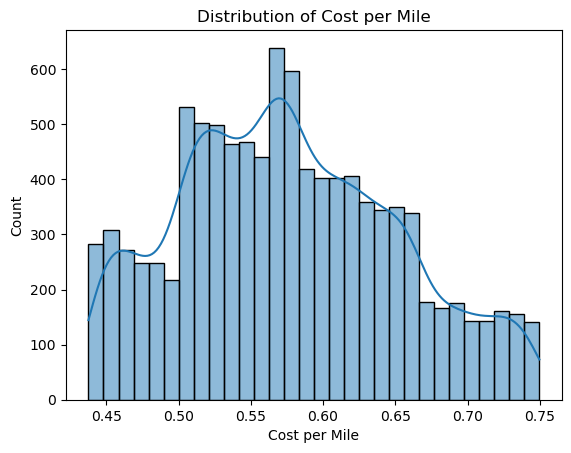

In [89]:
sns.histplot(logistics_df['Cost per Mile'], bins=30, kde=True)
plt.title("Distribution of Cost per Mile")
plt.show()


In [90]:
# Save the engineered data
logistics_df.to_csv('../data/processed/engineered_data.csv', index=False)


In [91]:
engineered_data = pd.read_csv('../data/processed/engineered_data.csv')
# Rounding to 4 decimal places for specific columns
columns_to_round = ["Actual Distance (miles)", "Planned Distance (miles)", "Calculated Fuel Cost (USD)"]
engineered_data[columns_to_round] = engineered_data[columns_to_round].round(4)

# Calculating "Distance Difference" and ensuring it's non-negative
engineered_data["Distance Difference (miles)"] = (engineered_data["Actual Distance (miles)"] - engineered_data["Planned Distance (miles)"]).clip(lower=0)

# Ensuring columns like "Weather Severity" aren't empty by assigning defaults
engineered_data["Weather Severity"] = np.random.choice([0, 1, 2, 3], size=10000)
engineered_data["Weather Severity Score"] = np.where(engineered_data["Weather Conditions"] == "Clear", 0, engineered_data["Weather Severity"])


Enhanced Modeling
a) Improved Feature Engineering for Regression Model

Add interaction terms and apply hyperparameter tuning for better performance.

In [92]:
# Interaction term: Distance and Truck Condition
logistics_df['Distance * Truck Condition'] = logistics_df['Actual Distance (miles)'] * logistics_df['Truck Condition']

# Define features and target
X = logistics_df[['Actual Distance (miles)', 'Truck Condition', 'Driver Ratings', 'Load Weight (tons)', 
                  'Traffic Conditions_Severe', 'Weather Severity Index', 'Distance * Truck Condition']]
y = logistics_df['Total Operational Cost (USD)']

# Hyperparameter tuning with GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE: 459.61314476902146
